Individual Assignment - Twitter Sentiment Analysis: Space travel - Cinthia Mimbela 

# Connecting to the API

In [2]:
# Importing libraries
import tweepy as tw
import config_twitter

In [3]:
# establish Twitter API connection
auth = tw.OAuthHandler(config_twitter.consumer_key, config_twitter.consumer_secret)
auth.set_access_token(config_twitter.access_token, config_twitter.access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [4]:
# returns False if credentials could not be verified, otherwise a user-object
user = api.verify_credentials()
user

User(_api=<tweepy.api.API object at 0x0000018C28846130>, _json={'id': 1416139937213259776, 'id_str': '1416139937213259776', 'name': 'Cinthia Mimbela', 'screen_name': 'CinthiaMimbela', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 0, 'listed_count': 0, 'created_at': 'Fri Jul 16 20:57:34 +0000 2021', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 0, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1416140077940477958/TRfBzTd7_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1416140077940477958/TRfBzTd7_normal.jpg', 'profile_

In [5]:
# Collecting relevant tweets through the Twitter API

import json
import tweepy as tw
import config_twitter

In [6]:
# Function to establish an initial API connection, respecting the rate limit

def connect_api_client():
    auth = tw.OAuthHandler(config_twitter.consumer_key, config_twitter.consumer_secret)
    auth.set_access_token(config_twitter.access_token, config_twitter.access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)
    try:
        api.verify_credentials()
        user = api.verify_credentials()
        if not user:
            raise("Credentials could not be verified: Please check config.py")
        print(f"Connected to Twitter API as {user.name}")
    except Exception as e:
        raise e
    return api

In [7]:
api = connect_api_client()

Connected to Twitter API as Cinthia Mimbela


In [8]:
# Search Query
query = '"space travel" OR "space tourism" -nasa -filter:retweets' #keywords
date_since = "2021-05-01" #recent tweets

# number of tweets to query
ntweets = 2000

In [9]:
# search and collect relevant tweets
tweets = [tweet._json for tweet in tw.Cursor(api.search, 
                                             q=query, 
                                             lang="en", 
                                             tweet_mode='extended', 
                                             since=date_since).items(ntweets)] 

# validating that there are 2,000 tweets
len(tweets)

2000

In [10]:
# example tweet content (json structure)
tweets[0]

{'created_at': 'Tue Jul 27 13:26:11 +0000 2021',
 'id': 1420012644174647303,
 'id_str': '1420012644174647303',
 'full_text': '@zithertilldawn @GeorgeMonbiot Yeah, just when, for the first time in millennia, humans were about to make life on Earth entirely safe, Bezos and Branson used THAT money for space travel! Damn, we came so close!\n\n🤔',
 'truncated': False,
 'display_text_range': [31, 214],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'zithertilldawn',
    'name': 'Mike Jessop ⧖⚫👁',
    'id': 3467728821,
    'id_str': '3467728821',
    'indices': [0, 15]},
   {'screen_name': 'GeorgeMonbiot',
    'name': 'George Monbiot',
    'id': 198584761,
    'id_str': '198584761',
    'indices': [16, 30]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://itunes.apple.com/us/app/twitter/id409789998?mt=12" rel="nofollow">Twitter for Mac</a>',
 'in_reply_to_status_id': 1420004029120356356,
 'in_re

In [11]:
# save tweets data to json file
file_out = f"raw_tweet_data_{ntweets}.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets, indent=2))

# Sentiment analysis

In [12]:
# Importing libraries
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [13]:
# Collecting the data in json-file
fjson = 'raw_tweet_data_2000.json'

# read json file with tweets data
with open(fjson) as file:
    data = json.load(file)

# validating that there are 2,000 tweets
len(data)

2000

In [14]:
# create pandas dataframe from tweet text content
df_tweets = pd.DataFrame([t['full_text'] for t in data], columns=['text'])

In [15]:
# add selected columns from tweet data fields
df_tweets['retweets'] = [t['retweet_count'] for t in data]
df_tweets['favorites'] = [t['favorite_count'] for t in data]
df_tweets['user'] = [t['user']['screen_name'] for t in data]

In [16]:
# text cleaning function
stop_words = set(stopwords.words('english'))

def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [17]:
# add clean text column
df_tweets['text_clean'] = df_tweets['text'].apply(text_cleanup)

In [18]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

pd.set_option("display.max_colwidth", None)

df_tweets['polarity'] = df_tweets['text_clean'].apply(sentim_polarity)
df_tweets['subjectivity'] = df_tweets['text_clean'].apply(sentim_subject)
df_tweets

,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,"@zithertilldawn @GeorgeMonbiot Yeah, just when, for the first time in millennia, humans were about to make life on Earth entirely safe, Bezos and Branson used THAT money for space travel! Damn, we came so close!\n\n🤔",0,0,tavi_chocochip,zithertilldawn georgemonbiot yeah first time millennia humans make life earth entirely safe bezos branson used money space travel damn came close,0.375000,0.416667
1,Why do tech billionaires spend their $$$ on boring space travel rather than on eel science? https://t.co/ZV8hREkCaA,0,0,EndoMetabPub,tech billionaires spend boring space travel rather eel science,-1.000000,1.000000
2,@Sam_Ash11414 Cuz they greedy and there are so many loop holes with taxes that corporations can take. Personally I don’t care they are literally advancing the human race towards space travel so it’s a small price to pay for being able to colonize Mars and shit,0,1,Ch33sy_TV,cuz greedy many loop holes taxes corporations take personally dont care literally advancing human race towards space travel small price pay able colonize mars shit,0.091667,0.454167
3,"@RocketRacer10 Space guys all seem to want to ""save humanity"" while having other interests...\n\nhttps://t.co/wD9m7lNjfL",0,0,BonaireVolt,rocketracer10 space guys seem want save humanity interests,0.000000,0.000000
4,"Humans,on a mission to destroy our planet,while they float in space,really.... https://t.co/xMt9X0CArc",0,0,Flyingpenguin63,humans mission destroy planet float space really,0.000000,0.100000
...,...,...,...,...,...,...,...
1995,@OfficialSPGB @elonmusk Then don't be an hypocrite and boycott/stop using anything that came with space travel. Start with satellite services for example.,0,2,MeisterRoshi,officialspgb elonmusk hypocrite using anything came space travel start satellite services example,0.000000,0.000000
1996,Tokyo Tonight! Space Travel and the Billionaire Boys Club https://t.co/cv635o2RMz https://t.co/lzKLPVoZNw,0,0,hikosaemon,tokyo tonight space travel billionaire boys club,0.000000,0.000000
1997,"Always looking for a new way to tax something, Congress considers a tax on space tourism\nhttps://t.co/zRG6k3DYPE",0,0,DwaynePhillips,always looking new way tax something congress considers tax space tourism,0.136364,0.454545
1998,"💫🌌 If humans can touch the stars, we can certainly end hunger here on earth.\n\nWe’re calling on the most powerful innovators to join us in solving one of the world’s most pressing problems.\n\nUnlike space travel, ending hunger is not rocket science. \n\nThere is #SpaceforBoth https://t.co/AspKE9Lwo3",0,2,WFP_Africa,humans touch stars certainly end hunger earth calling powerful innovators join us solving one worlds pressing problems unlike space travel ending hunger rocket science spaceforboth,0.257143,0.785714


The number of negative sentiment tweets is: 402
Percentage is: 20.0%
The number of neutral sentiment tweets is: 612
Percentage is: 31.0%
The number of positive sentiment tweets is: 986
Percentage is: 49.0%


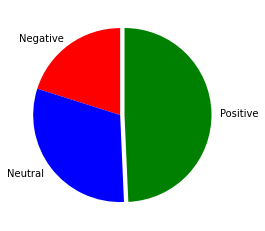

In [45]:
print( f"The number of negative sentiment tweets is: {sum(n < 0 for n in df_tweets['polarity'])}")
print( f"Percentage is: {round(sum(n < 0 for n in df_tweets['polarity'])/len(df_tweets),2)*100}%")
print( f"The number of neutral sentiment tweets is: {sum(n == 0 for n in df_tweets['polarity'])}")
print( f"Percentage is: {round(sum(n == 0 for n in df_tweets['polarity'])/len(df_tweets),2)*100}%")
print( f"The number of positive sentiment tweets is: {sum(n > 0 for n in df_tweets['polarity'])}")
print( f"Percentage is: {round(sum(n > 0 for n in df_tweets['polarity'])/len(df_tweets),2)*100}%")

sentiment = np.array([sum(n < 0 for n in df_tweets['polarity']),
                      sum(n == 0 for n in df_tweets['polarity']), 
                      sum(n > 0 for n in df_tweets['polarity'])])

mylabels = ["Negative", "Neutral", "Positive"]
myexplode = [0,0,0.05]
mycolors = ["r","b","g"]

plt.pie(sentiment, labels=mylabels, explode=myexplode, startangle=90, colors=mycolors)
plt.show() 

In [52]:
# highest sentiment tweets
df_tweets.sort_values(by=['polarity','subjectivity'], ascending=False).head(20)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
1031,"@JeffreyGuterman @blowfish8888 When space travel was ""real"" lol!",0,1,Polish333,jeffreyguterman blowfish8888 space travel real lol,1.00,1.000
1910,"Now that space travel is getting commercialized, how awesome would a hotel stay be in space.",0,1,Chase__Profits,space travel getting commercialized awesome would hotel stay space,1.00,1.000
1587,@AuraJustAura Best series of space travel ever,0,1,bloodjetpoetry,aurajustaura best series space travel ever,1.00,0.300
1647,You just made the best argument for space travel yet. Buddhism is cringe https://t.co/DN962Z1XcV,0,3,ZephyrAugustus,made best argument space travel yet buddhism cringe,1.00,0.300
1521,"Absolutely the best piece I've read about this monumental ego-centric bullshit called 'space tourism'. \nFFS, just because you have the $$$ to build and travel on your own Concorde does not make you a fuckin' Concorde pilot. Brilliant from @profgalloway \n\nhttps://t.co/SthEAmtmAg",0,1,AnantDeboor,absolutely best piece read monumental bullshit called tourism ffs build travel concorde make fuckin concorde pilot brilliant profgalloway,0.95,0.650
402,"Wait, @SpaceX have only built 100 Raptor engines?! This is an incredible feat for space travel! https://t.co/8DyL1o9XhK",0,1,njbmartin,wait spacex built 100 raptor engines incredible feat space travel,0.90,0.900
360,@SpaceX @elonmusk That is an awesome achievement guys!! Great work and thank you for continuing to build forward for our space travel!,0,0,fsStudiosUS,spacex elonmusk awesome achievement guys great work thank continuing build forward space travel,0.90,0.875
1445,My other best friend in buissness and life.. he’s a great artist.. whom changed my perspective on art and space travel.. this guy is an artist! And Elon is like zuckerberg on steroids!!! https://t.co/etu5nbaVGT https://t.co/FXkxUjIwIw,1,0,danielthe956GOD,best friend buissness life hes great artist changed perspective art space travel guy artist elon like zuckerberg steroids,0.90,0.525
1741,make shiba investors happy and reduce shiba supply and let shibanin space travel begin\n@Shibtoken \n#SHIB \n#SHIBARMY \n#ShibaSwap \n#ShibaCoin \n#shiba,1,3,ShibaCoin12,make shiba investors happy reduce shiba supply let shibanin space travel begin shibtoken shib shibarmy shibaswap shibacoin shiba,0.80,1.000
92,"Fly to Edge of Space on a MiG-29, experience Zero gravity and more https://t.co/OHccB7jRwr",0,1,DefenceAviation,fly edge space experience zero gravity,0.80,0.900


In [51]:
# lowest sentiment tweets
df_tweets.sort_values(by=['polarity','subjectivity'], ascending=True).head(20) 

,text,retweets,favorites,user,text_clean,polarity,subjectivity
1,Why do tech billionaires spend their $$$ on boring space travel rather than on eel science? https://t.co/ZV8hREkCaA,0,0,EndoMetabPub,tech billionaires spend boring space travel rather eel science,-1.0,1.000000
1885,Billionaires are making space travel so fucking boring!,1,1,ConnorClockwise,billionaires making space travel fucking boring,-1.0,1.000000
1949,"@HOMOCOSMICUSv2 @CuriepolisBuch I hope so. Or Space Travel would get really boring. In that case they would not visit us, but just send a communication robot. And nothing more, for the rest of eternity.",0,1,PhoenixArtist3,homocosmicusv2 curiepolisbuch hope space travel would get really boring case would visit us send communication robot nothing rest eternity,-1.0,1.000000
948,"@tl_trevaskis @AudreyStJames1 @Carpediem4989 No. In the context of SPACE TOURISM. ffs, people idiots about this topic.",0,0,BobC7000,audreystjames1 carpediem4989 context space tourism ffs people idiots topic,-0.8,0.800000
262,I hate privatized space travel.,0,2,JOANNAessayist,hate privatized space travel,-0.8,0.900000
923,@pvfreud @ewarren Space tourism? Bezos just proposed putting all the polluting industries into space. Why would anyone want to risk their life to visit a filthy industrial wasteland in outer space?,0,0,RobWalls16,pvfreud ewarren space tourism bezos proposed putting polluting industries space would anyone want risk life visit filthy industrial wasteland outer space,-0.8,1.000000
1637,@FinJCam @CutieMari3 billionaire space race is stupid. its just saying “look we have money and we can go to space.” its not helping space travel become easier for people who dont have billions of dollars. i think we need to focus on that more,0,2,qtZazu,finjcam cutiemari3 billionaire space race stupid saying look money go space helping space travel become easier people dont billions dollars think need focus,-0.8,1.000000
170,Happytrips: Race for space travel—a seemingly vulgar display of wealth.\nhttps://t.co/xQqZDjITh8\n\nvia @GoogleNews,0,0,JosephHucks,happytrips race space travela seemingly vulgar display wealth via googlenews,-0.7,0.800000
739,Race for space travel—a seemingly vulgar display of wealth \n\n#spacetravel\n#travel\n\nhttps://t.co/GOKgiScktx,0,0,TOItravel,race space travela seemingly vulgar display wealth spacetravel travel,-0.7,0.800000
1318,The expanse stays showing that space travel is gonna be awful for poor people,0,1,ApokolipsPimp,expanse stays showing space travel gon na awful poor people,-0.7,0.800000


In [54]:
# most retweeted and liked content (in that order)
df_tweets.sort_values(by=['retweets','favorites'], ascending=False).head(20)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
1761,"why spend your money on space travel when you could buy a gothic castle, fill it to the rafters with obscure texts, live out the rest of your life in comfortable seclusion and then leave your entire fortune to the person who can solve the riddle hidden in your collection",450,2570,Sotherans,spend money space travel could buy gothic castle fill rafters obscure texts live rest life comfortable seclusion leave entire fortune person solve riddle hidden collection,0.092424,0.564583
1146,I refuse to talk about billionaire space travel until we start dealing with the climate disaster we're already experiencing https://t.co/I2FldEs0Pw,147,821,thediyora,refuse talk billionaire space travel start dealing climate disaster already experiencing,0.000000,0.000000
348,Space tourism: Rockets emit 100 times more CO2 per passenger than flights – imagine a whole industry https://t.co/ypqinXj77k https://t.co/xJtHTV6jWy,81,301,SPACEdotcom,space tourism rockets emit 100 times co2 per passenger flights imagine whole industry,0.200000,0.400000
683,"The rise of space tourism could affect Earth's climate in unforeseen ways, scientists worry https://t.co/cnccf93P6J https://t.co/oRuTSZhtVy",70,452,SPACEdotcom,rise space tourism could affect earth climate unforeseen ways scientists worry,0.000000,0.000000
1999,"“We must call this out for what it is. This is an entertainment business for the super-rich, backed by a formidable PR operation.” \n\n— #AJOpinion by @Johnny__Luk https://t.co/ex12t3YtP4",66,235,AJEnglish,must call entertainment business backed formidable pr operation ajopinion,0.000000,0.000000
628,"Elizabeth Warren Slams Jeff Bezos Over Space Tourism Trip, Calls for a Wealth Tax https://t.co/ghtkSfRwrZ",65,250,realTuckFrumper,elizabeth warren slams jeff bezos space tourism trip calls wealth tax,0.000000,0.000000
1213,"Space tourism is not space exploration\nits beginning of a new fossil fuel powered business for billionaires to get their kicks in space, watching the spectacle of a burnt out and flooded Earth, as they fuel even more emissions",63,206,ECOWARRIORSS,space tourism space exploration beginning new fossil fuel powered business billionaires get kicks space watching spectacle burnt flooded earth fuel even emissions,0.136364,0.454545
1971,"Space tourism will be worth $8bn by 2030, but that’s a fraction of today’s $350bn space industry.\n\nBeyond tourism, who will dominate the $1 trillion space economy?\n\n👉 https://t.co/ggVUkF2ZzW | #AJCTC https://t.co/XsBix3DT7Q",50,133,AJEnglish,space tourism worth 8bn 2030 thats fraction todays 350bn space industry beyond tourism dominate 1 trillion space economy ajctc,0.300000,0.100000
1658,Should the United States increase funding for space travel?,50,46,UPP_Polls,united states increase funding space travel,0.000000,0.000000
347,"For one long-haul plane flight, it’s one to three tons of carbon dioxide [per passenger]... For one rocket launch 200-300 tonnes of carbon dioxide are split between 4 passengers.\n\nIt doesn’t need to grow that much more to compete with other sources. https://t.co/hWLTitk8gO",48,61,PaulEDawson,one plane flight one three tons carbon dioxide per passenger one rocket launch tonnes carbon dioxide split 4 passengers doesnt need grow much compete sources,0.200000,0.200000


In [102]:
# creating an array with unique users and adding up their retweets and favorites (likes)
array_unique = []

for tp in df_tweets['user'].unique():
    rt = df_tweets[df_tweets['user'] == tp]['retweets'].sum()
    lk = df_tweets[df_tweets['user'] == tp]['favorites'].sum()
    array_unique.append([tp,rt,lk])
    
    df_unique = pd.DataFrame(array_unique, columns=["user", "retweets","favorites"])

# sorting this new array by retweets and favorites and indexing user column
df_unique.sort_values(by=['retweets','favorites'], ascending=False, inplace = True)
df_unique.set_index('user', inplace = True)
df_unique

,retweets,favorites
user,,
Sotherans,450,2570
SPACEdotcom,151,753
thediyora,147,821
AJEnglish,129,424
realTuckFrumper,73,261
...,...,...
PeteCEng1,0,0
geologyteacher,0,0
FurtherRussia,0,0


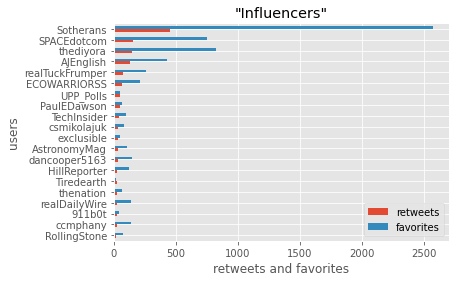

In [106]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_unique.head(20).sort_values(by='retweets').plot(kind = 'barh')
plt.title('"Influencers"')
plt.ylabel('users')
plt.xlabel('retweets and favorites')
plt.legend().set_visible(True)
plt.show()

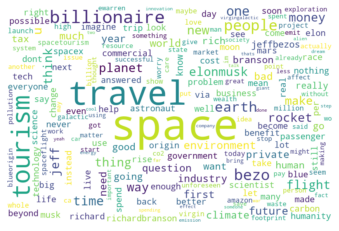

In [117]:
# most common tweet content - keywords for the 2,000 tweets

mask = np.array(Image.open(r"C:\Users\CINTHIA MIMBELA\rocket.png"))

wc = WordCloud(mask=mask, 
               background_color='white', 
               width=mask.shape[1], 
               height=mask.shape[0], 
               max_font_size=110, 
               collocations=False).generate(' '.join(df_tweets['text_clean']))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


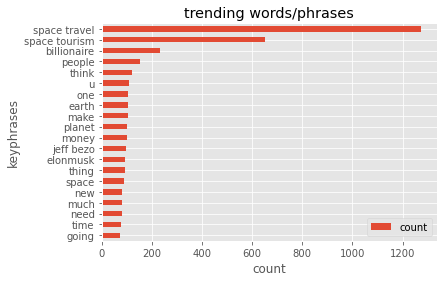

In [126]:
# alternative visualization, extract the keyword counts
kwords = WordCloud().process_text(' '.join(df_tweets['text_clean']))

# transform that dictionary into a pandas DataFrame and index: keyword
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')

# Sorting the dataframe
df_kwords.sort_values(by='count', ascending=False, inplace=True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_kwords.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('trending words/phrases')
plt.ylabel('keyphrases')
plt.xlabel('count')
plt.legend().set_visible(True)
plt.show()

In [130]:
df_tweets[df_tweets['text_clean'].str.contains(" u ")==True].index

Int64Index([12, 145, 248, 314, 662, 763, 788, 1021, 1508, 1917], dtype='int64')

In [140]:
display(df_tweets['text'].iloc[12])

'@elonmusk Honest Q. What do we (you) put so much money into space travel when u can divert that resources to help the planet we live on? I do like u, u are an inspiration and my spirit animal, but that has bothering me a lot.'

In [149]:
# tweets for each brand
print(f"{df_tweets[df_tweets['text_clean'].str.contains('spacex')]['text'].count()} tweets of SpaceX")
print(f"{df_tweets[df_tweets['text_clean'].str.contains('blue origin')]['text'].count()} tweets of Blue Origin")
print(f"{df_tweets[df_tweets['text_clean'].str.contains('virgin galactic')]['text'].count()} tweets of Virgin Galactic")

59 tweets of SpaceX
28 tweets of Blue Origin
21 tweets of Virgin Galactic


In [150]:
# list of brands to analyze
brands = ['spacex', 'blue origin', 'virgin galactic']
# brand comparison dataframe
df_brands = pd.DataFrame(brands, columns=['brand'])

# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets[df_tweets['text_clean'].str.contains(b)]['polarity'].mean()

# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands

,brand,average_sentiment
0,spacex,0.160950
1,blue origin,0.023166
2,virgin galactic,0.101005


# SpaceX

In [151]:
# Search Query
query = '"spacex" -nasa -filter:retweets' #keywords

# search and collect relevant tweets
tweets_spacex = [tweet._json for tweet in tw.Cursor(api.search, 
                                             q=query, 
                                             lang="en", 
                                             tweet_mode='extended', 
                                             since=date_since).items(ntweets)] 

# number od tweets collected
len(tweets_spacex)

267

In [155]:
# save tweets data to json file
file_out = f"raw_tweet_data_spacex.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets_spacex, indent=2))
    
# collecting the data of SpaceX in json-file
fjson_spacex = 'raw_tweet_data_spacex.json'

# read json file with tweets data
with open(fjson_spacex) as file:
    data_spacex = json.load(file)

# create pandas dataframe from tweet text content
df_tspacex = pd.DataFrame([t['full_text'] for t in data_spacex], columns=['text'])

# add selected columns from tweet data fields
df_tspacex['retweets'] = [t['retweet_count'] for t in data_spacex]
df_tspacex['favorites'] = [t['favorite_count'] for t in data_spacex]
df_tspacex['user'] = [t['user']['screen_name'] for t in data_spacex]

# add clean text column
df_tspacex['text_clean'] = df_tspacex['text'].apply(text_cleanup)

# add polarity and subjectivity
df_tspacex['polarity'] = df_tspacex['text_clean'].apply(sentim_polarity)
df_tspacex['subjectivity'] = df_tspacex['text_clean'].apply(sentim_subject)

# average sentiment of SpaceX
print(f"The average sentiment of SpaceX is {round(df_tspacex['polarity'].mean(),2)}")


The average sentiment of SpaceX is 0.12


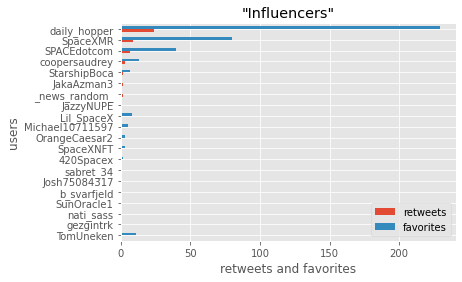

In [158]:
# creating an array with unique users and adding up their retweets and favorites (likes)
array_unique_spacex = []

for tp in df_tspacex['user'].unique():
    rt = df_tspacex[df_tspacex['user'] == tp]['retweets'].sum()
    lk = df_tspacex[df_tspacex['user'] == tp]['favorites'].sum()
    array_unique_spacex.append([tp,rt,lk])
    
    df_unique_spacex = pd.DataFrame(array_unique_spacex, columns=["user", "retweets","favorites"])

# sorting this new array by retweets and favorites and indexing user column
df_unique_spacex.sort_values(by=['retweets','favorites'], ascending=False, inplace = True)
df_unique_spacex.set_index('user', inplace = True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_unique_spacex.head(20).sort_values(by='retweets').plot(kind = 'barh')
plt.title('"Influencers"')
plt.ylabel('users')
plt.xlabel('retweets and favorites')
plt.legend().set_visible(True)
plt.show()

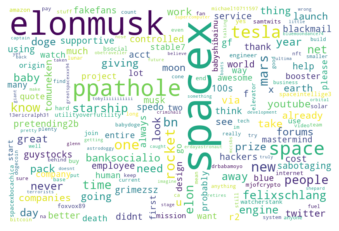

In [159]:
# most common tweet content of SpaceX - keywords for the 267 tweets

mask = np.array(Image.open(r"C:\Users\CINTHIA MIMBELA\rocket.png"))

wc = WordCloud(mask=mask, 
               background_color='white', 
               width=mask.shape[1], 
               height=mask.shape[0], 
               max_font_size=110, 
               collocations=False).generate(' '.join(df_tspacex['text_clean']))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

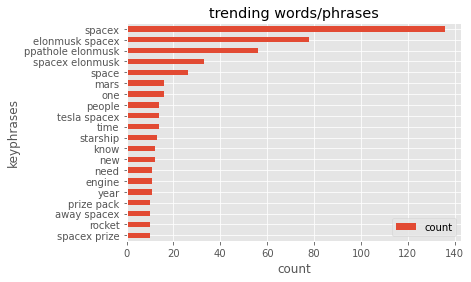

In [160]:
# alternative visualization, extract the keyword counts
kwords_spacex = WordCloud().process_text(' '.join(df_tspacex['text_clean']))

# transform that dictionary into a pandas DataFrame and index: keyword
df_kwords_spacex = pd.DataFrame(list(kwords_spacex.items()), columns=['keyword', 'count']).set_index('keyword')

# Sorting the dataframe
df_kwords_spacex.sort_values(by='count', ascending=False, inplace=True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_kwords_spacex.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('trending words/phrases')
plt.ylabel('keyphrases')
plt.xlabel('count')
plt.legend().set_visible(True)
plt.show()

# Blue Origin

In [161]:
# Search Query
query = '"blue origin" -nasa -filter:retweets' #keywords

# search and collect relevant tweets
tweets_bo = [tweet._json for tweet in tw.Cursor(api.search, 
                                             q=query, 
                                             lang="en", 
                                             tweet_mode='extended', 
                                             since=date_since).items(ntweets)] 

# number od tweets collected
len(tweets_bo)

2000

In [162]:
# save tweets data to json file
file_out = f"raw_tweet_data_bo.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets_bo, indent=2))
    
# collecting the data of SpaceX in json-file
fjson_bo = 'raw_tweet_data_bo.json'

# read json file with tweets data
with open(fjson_bo) as file:
    data_bo = json.load(file)

# create pandas dataframe from tweet text content
df_tbo = pd.DataFrame([t['full_text'] for t in data_bo], columns=['text'])

# add selected columns from tweet data fields
df_tbo['retweets'] = [t['retweet_count'] for t in data_bo]
df_tbo['favorites'] = [t['favorite_count'] for t in data_bo]
df_tbo['user'] = [t['user']['screen_name'] for t in data_bo]

# add clean text column
df_tbo['text_clean'] = df_tbo['text'].apply(text_cleanup)

# add polarity and subjectivity
df_tbo['polarity'] = df_tbo['text_clean'].apply(sentim_polarity)
df_tbo['subjectivity'] = df_tbo['text_clean'].apply(sentim_subject)

# average sentiment of Blue Origin
print(f"The average sentiment of Blue Origin is {round(df_tbo['polarity'].mean(),2)}")


The average sentiment of Blue Origin is 0.05


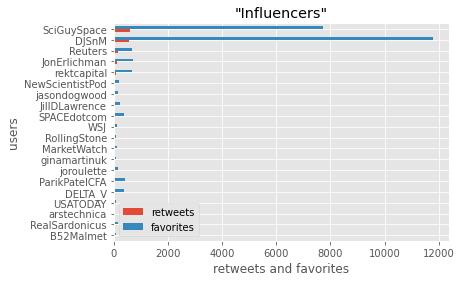

In [164]:
# creating an array with unique users and adding up their retweets and favorites (likes)
array_unique_bo = []

for tp in df_tbo['user'].unique():
    rt = df_tbo[df_tbo['user'] == tp]['retweets'].sum()
    lk = df_tbo[df_tbo['user'] == tp]['favorites'].sum()
    array_unique_bo.append([tp,rt,lk])
    
    df_unique_bo = pd.DataFrame(array_unique_bo, columns=["user", "retweets","favorites"])

# sorting this new array by retweets and favorites and indexing user column
df_unique_bo.sort_values(by=['retweets','favorites'], ascending=False, inplace = True)
df_unique_bo.set_index('user', inplace = True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_unique_bo.head(20).sort_values(by='retweets').plot(kind = 'barh')
plt.title('"Influencers"')
plt.ylabel('users')
plt.xlabel('retweets and favorites')
plt.legend().set_visible(True)
plt.show()

In [172]:
df_tbo[df_tbo['user'].str.contains("DJSnM")==True]

,text,retweets,favorites,user,text_clean,polarity,subjectivity
654,"I just thought I'd put this out there since there are people repeating the myth that SpaceX is only succeeding because it's getting government money it doesn't deserve, while Blue Origin is completely self funded.\nBoth are getting government money to develop technology.",68,2453,DJSnM,thought put since people repeating myth spacex succeeding getting government money deserve blue origin completely self funded getting government money develop technology,0.050000,0.250000
656,"As of right now The National Team, led by Blue Origin has received more HLS development funds than the current winner, SpaceX. \n$579 million for National Team\n$135 million for SpaceX.\n\nFurther funding for the winner is awaiting results of protest.",476,9327,DJSnM,right national team led blue origin received hls development funds current winner spacex 579 million national team 135 million spacex funding winner awaiting results protest,0.095238,0.345238


In [173]:
df_tbo[df_tbo['user'].str.contains("SciGuySpace")==True]

,text,retweets,favorites,user,text_clean,polarity,subjectivity
251,Blue Origin is developing a reusable upper stage for its New Glenn rocket in order to be more competitive with SpaceX's Starship vehicle. This project is seen as important to company's launch viability.\n\nhttps://t.co/j2xzJ0xFM3,163,1543,SciGuySpace,blue origin developing reusable upper stage new glenn rocket order competitive spacex starship vehicle project seen important company launch viability,0.134091,0.388636
556,Unofficially—because Blue Origin never talks about these things publicly—I've heard that a total of nine BE-4 engines have been built as part of the development program so far. Nine. Zero currently on the test stand. https://t.co/i8RlOTsYxJ,181,2814,SciGuySpace,unofficiallybecause blue origin never talks things publiclyi heard total nine engines built part development program far nine zero currently test stand,0.025000,0.562500
764,"Good catch here. Blue Origin emphasizing JOBS, which is the love language of Congress. https://t.co/5f7FzHwh4m",12,315,SciGuySpace,good catch blue origin emphasizing jobs love language congress,0.400000,0.433333
776,"This is exactly what Blue Origin should have done *during* the competition, before the contracts were awarded. SpaceX won partly because they put the most skin in the game. https://t.co/2khZRNyaid",102,1235,SciGuySpace,exactly blue origin done competition contracts awarded spacex partly put skin game,-0.200000,0.250000
1403,@enzovit0 @jamesbuchanan27 It's safe to say Bob is the main reason Blue Origin has moved more slowly.,1,47,SciGuySpace,enzovit0 jamesbuchanan27 safe say bob main reason blue origin moved slowly,0.091667,0.333333
1425,@NuancedT4kes This story may help.\n\nhttps://t.co/dwU6lgRhK9,0,10,SciGuySpace,nuancedt4kes story may help,0.000000,0.000000
1431,The disparity in CEO approval on Glassdoor is remarkable among these U.S. rocket companies.\n\nRelativity: 95 percent\nSpaceX: 92 percent\nRocket Lab: 81 percent\nBlue Origin: 18 percent https://t.co/hzkPj8oX9B,148,1770,SciGuySpace,disparity ceo approval glassdoor remarkable among rocket companies relativity 95 percent spacex 92 percent rocket lab 81 percent blue origin 18 percent,0.375000,0.425000


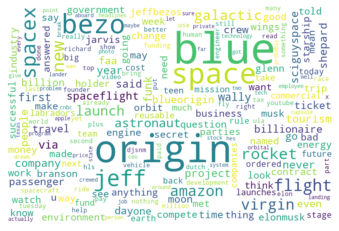

In [174]:
# most common tweet content of Blue Origin - keywords for the 2,000 tweets

mask = np.array(Image.open(r"C:\Users\CINTHIA MIMBELA\rocket.png"))

wc = WordCloud(mask=mask, 
               background_color='white', 
               width=mask.shape[1], 
               height=mask.shape[0], 
               max_font_size=110, 
               collocations=False).generate(' '.join(df_tbo['text_clean']))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

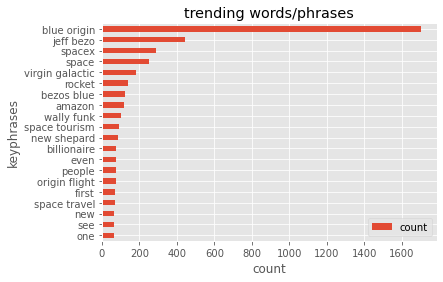

In [175]:
# alternative visualization, extract the keyword counts
kwords_bo = WordCloud().process_text(' '.join(df_tbo['text_clean']))

# transform that dictionary into a pandas DataFrame and index: keyword
df_kwords_bo = pd.DataFrame(list(kwords_bo.items()), columns=['keyword', 'count']).set_index('keyword')

# Sorting the dataframe
df_kwords_bo.sort_values(by='count', ascending=False, inplace=True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_kwords_bo.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('trending words/phrases')
plt.ylabel('keyphrases')
plt.xlabel('count')
plt.legend().set_visible(True)
plt.show()

# Virgin Galactic

In [176]:
# Search Query
query = '"virgin galactic" -nasa -filter:retweets' #keywords

# search and collect relevant tweets
tweets_vg = [tweet._json for tweet in tw.Cursor(api.search, 
                                             q=query, 
                                             lang="en", 
                                             tweet_mode='extended', 
                                             since=date_since).items(ntweets)] 

# number od tweets collected
len(tweets_vg)

234

In [179]:
# save tweets data to json file
file_out = f"raw_tweet_data_vg.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets_vg, indent=2))
    
# collecting the data of SpaceX in json-file
fjson_vg = 'raw_tweet_data_vg.json'

# read json file with tweets data
with open(fjson_vg) as file:
    data_vg = json.load(file)

# create pandas dataframe from tweet text content
df_tvg = pd.DataFrame([t['full_text'] for t in data_vg], columns=['text'])

# add selected columns from tweet data fields
df_tvg['retweets'] = [t['retweet_count'] for t in data_vg]
df_tvg['favorites'] = [t['favorite_count'] for t in data_vg]
df_tvg['user'] = [t['user']['screen_name'] for t in data_vg]

# add clean text column
df_tvg['text_clean'] = df_tvg['text'].apply(text_cleanup)

# add polarity and subjectivity
df_tvg['polarity'] = df_tvg['text_clean'].apply(sentim_polarity)
df_tvg['subjectivity'] = df_tvg['text_clean'].apply(sentim_subject)

# average sentiment of Virgin Galactic
print(f"The average sentiment of Virgin Galactic is {round(df_tvg['polarity'].mean(),2)}")


The average sentiment of Virgin Galactic is 0.05


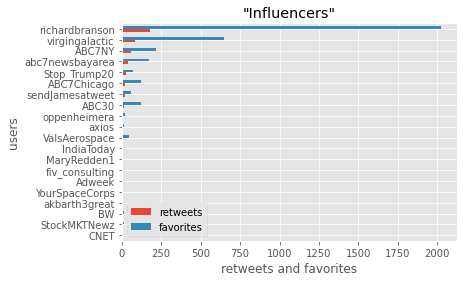

In [180]:
# creating an array with unique users and adding up their retweets and favorites (likes)
array_unique_vg = []

for tp in df_tvg['user'].unique():
    rt = df_tvg[df_tvg['user'] == tp]['retweets'].sum()
    lk = df_tvg[df_tvg['user'] == tp]['favorites'].sum()
    array_unique_vg.append([tp,rt,lk])
    
    df_unique_vg = pd.DataFrame(array_unique_vg, columns=["user", "retweets","favorites"])

# sorting this new array by retweets and favorites and indexing user column
df_unique_vg.sort_values(by=['retweets','favorites'], ascending=False, inplace = True)
df_unique_vg.set_index('user', inplace = True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_unique_vg.head(20).sort_values(by='retweets').plot(kind = 'barh')
plt.title('"Influencers"')
plt.ylabel('users')
plt.xlabel('retweets and favorites')
plt.legend().set_visible(True)
plt.show()

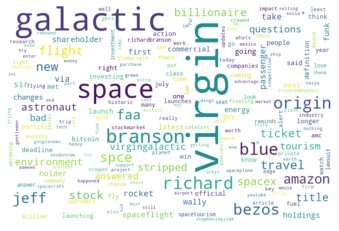

In [183]:
# most common tweet content of Virgin Galactic - keywords for the 234 tweets

mask = np.array(Image.open(r"C:\Users\CINTHIA MIMBELA\rocket.png"))

wc = WordCloud(mask=mask, 
               background_color='white', 
               width=mask.shape[1], 
               height=mask.shape[0], 
               max_font_size=110, 
               collocations=False).generate(' '.join(df_tvg['text_clean']))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

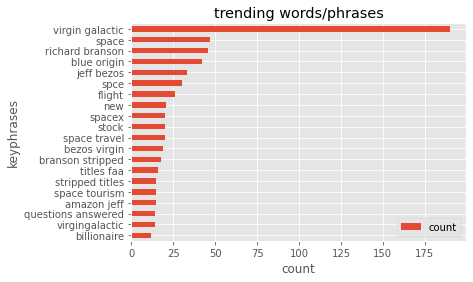

In [184]:
# alternative visualization, extract the keyword counts
kwords_vg = WordCloud().process_text(' '.join(df_tvg['text_clean']))

# transform that dictionary into a pandas DataFrame and index: keyword
df_kwords_vg = pd.DataFrame(list(kwords_vg.items()), columns=['keyword', 'count']).set_index('keyword')

# Sorting the dataframe
df_kwords_vg.sort_values(by='count', ascending=False, inplace=True)

plt.style.use('ggplot')

# render a horizontal bar graph
df_kwords_vg.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('trending words/phrases')
plt.ylabel('keyphrases')
plt.xlabel('count')
plt.legend().set_visible(True)
plt.show()